In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-pearsemurphy04')


In [5]:
import csv
from datetime import datetime
import geemap
from geemap import geojson_to_ee
from ipyleaflet import GeoJSON
import geojson
from geojson import Feature, FeatureCollection, dump
from eo_utils import geojson_to_shapely
import shapely
from shapely import Polygon
import json
import numpy as np

In [6]:
def dump_poly(poly, outfile):
    features = []
    features.append(Feature(geometry=poly))
    feature_collection = FeatureCollection(features)
    with open(outfile, "w") as gj:
        dump(feature_collection, gj)
    return

In [7]:
def separate_park(roi_json, park_json, park_name):
    roi_poly = geojson_to_shapely(roi_json)
    park_poly = geojson_to_shapely(park_json)
    inside_park = roi_poly & park_poly
    outside_park = roi_poly ^ inside_park
    dump_poly(inside_park, f"/data/tapas/pearse/malawi/sentinel1/aoi/inside_{park_name}.geojson")
    dump_poly(outside_park, f"/data/tapas/pearse/malawi/sentinel1/aoi/outside_{park_name}.geojson")
    return inside_park, outside_park

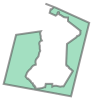

In [8]:
inside_kasungu, outside_kasungu = separate_park("/data/tapas/pearse/malawi/sentinel1/aoi/kasungu_small.geojson", "/data/tapas/pearse/malawi/sentinel1/aoi/kasungu_np.geojson", "kasungu")
inside_liwonde, outside_liwonde = separate_park("/data/tapas/pearse/malawi/sentinel1/aoi/southern_malawi_aoi.geojson", "/data/tapas/pearse/malawi/sentinel1/aoi/liwonde_np.geojson", "liwonde")
outside_liwonde

In [11]:
modis_col = ee.ImageCollection("MODIS/061/MOD09A1")
modis_vi_col = ee.ImageCollection("MODIS/061/MOD13A1")
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")


Malawi = countries.filter(ee.Filter.eq('ADM0_NAME', 'Malawi'))
modis_im = modis_col.filterDate("2023-01-01", "2024-05-31").filterBounds(Malawi).sort("system:time_start", False).first()
modis_vi_im = modis_vi_col.filterDate("2023-01-01", "2024-05-31").filterBounds(Malawi).sort("system:time_start", False).first()
modis_vi_im = modis_vi_im.multiply(0.0001)

# gj_file = "/data/tapas/pearse/malawi/sentinel1/aoi/kasungu_small.geojson"
outside_file = "/data/tapas/pearse/malawi/sentinel1/aoi/outside_liwonde.geojson"
inside_file = "/data/tapas/pearse/malawi/sentinel1/aoi/inside_liwonde.geojson"
# with open(gj_file) as gj:
#     poly_coords = geojson.load(gj)

with open(outside_file) as tgj:
    outside_liwonde = geojson.load(tgj)
    
with open(inside_file) as tgj:
    inside_liwonde = geojson.load(tgj)

visParams = {"bands": ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'], "min":0, "max":3000}
Map = geemap.Map(zoom=5)
Map.centerObject(Malawi)
Map.addLayer(modis_im.clip(Malawi), visParams)
Map.addLayer(modis_vi_im.clip(Malawi), {"bands":"NDVI", "min":-0.5, "max":0.5, "palette":["blue", "white","forestgreen"]})
# json_layer = GeoJSON(
#     data=poly_coords,
#     name="liwonde ROI",
#     hover_style={"fillColor": "red", "fillOpacity": 0.5},
# )
# Map.add_layer(json_layer)
outside_liwonde_ee = geojson_to_ee(outside_liwonde)
inside_liwonde_ee = geojson_to_ee(inside_liwonde)
Map.addLayer(outside_liwonde_ee, {}, "liwonde EE")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [12]:
outside_liwonde_ee.geometry()

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection",
          "arguments": {
            "features": {
              "arrayValue": {
                "values": [
                  {
                    "functionInvocationValue": {
                      "functionName": "Feature",
                      "arguments": {
                        "geometry": {
                          "functionInvocationValue": {
                            "functionName": "GeometryConstructors.Polygon",
                            "arguments": {
                              "coordinates": {
                                "constantValue": [
                                  [
                                    [
                                      35.3422,
                                      -14.7404
                                    ],
                                    [
                                      35.4723,
                                      -14.7994
                                    ],
                                    [
                                      35.4017,
                                      -15.0851
                                    ],
                                    [
                                      35.1398,
                                      -15.037
                                    ],
                                    [
                                      35.188,
                                      -14.846
                                    ],
                                    [
                                      35.284035,
                                      -14.832188
                                    ],
                                    [
                                      35.283941,
                                      -14.832333
                                    ],
                                    [
                                      35.28385,
                                      -14.832474
                                    ],
                                    [
                                      35.283706,
                                      -14.832706
                                    ],
                                    [
                                      35.283396,
                                      -14.833247
                                    ],
                                    [
                                      35.283278,
                                      -14.833469
                                    ],
                                    [
                                      35.283161,
                                      -14.833683
                                    ],
                                    [
                                      35.282786,
                                      -14.83445
                                    ],
                                    [
                                      35.282678,
                                      -14.834704
                                    ],
                                    [
                                      35.282522,
                                      -14.835094
                                    ],
                                    [
                                      35.282449,
                                      -14.835289
                                    ],
                                    [
                                      35.282369,
                                      -14.835507
                                    ],
                                    [
                                      35.282224,
                                      -14.835928
                                    ],
                                    [
                     

In [14]:
def mean_in_region(image):
    mean = image.reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = outside_kasungu_ee.geometry(),
        scale = 500,
        )
    return mean

In [15]:
ndvi_col = modis_vi_col.filterDate("2023-01-01", "2024-05-31").select("NDVI")
ndvi_col = ndvi_col.map(lambda img: img.multiply(0.0001))

In [16]:
ndvi_col

In [17]:
import os

In [217]:
out_dir = "/data/tapas/pearse/ee_downloads"
out_stats = os.path.join(out_dir, "outside_liwonde_mean_ndvi.csv")
in_stats = os.path.join(out_dir, "inside_liwonde_mean_ndvi.csv")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for stats, region in zip([out_stats, in_stats], [outside_liwonde_ee, inside_liwonde_ee]):
    geemap.zonal_stats(ndvi_col, region, stats, stat_type="MEAN", scale=500)


Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /data/tapas/pearse/ee_downloads/outside_liwonde_mean_ndvi.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /data/tapas/pearse/ee_downloads/inside_liwonde_mean_ndvi.csv


In [46]:
out_dir = "/data/tapas/pearse/ee_downloads"
out_stats_liwonde = os.path.join(out_dir, "outside_liwonde_mean_ndvi.csv")
in_stats_liwonde = os.path.join(out_dir, "inside_liwonde_mean_ndvi.csv")
out_stats_kasungu = os.path.join(out_dir, "outside_kasungu_mean_ndvi.csv")
in_stats_kasungu = os.path.join(out_dir, "inside_kasungu_mean_ndvi.csv")

ndvi_means = {"inside":[], "outside":[]}
for in_stats in [in_stats_liwonde, in_stats_kasungu]:
    with open(in_stats) as stats:
        csv_read = csv.reader(stats)

        date_row = next(csv_read)
        data_row = next(csv_read)
    ndvi_means["inside"].append(np.array(data_row[:-1], dtype=float))

for out_stats in [out_stats_liwonde, out_stats_kasungu]:
    with open(out_stats) as stats:
        csv_read = csv.reader(stats)

        date_row = next(csv_read)
        data_row = next(csv_read)
    ndvi_means["outside"].append(np.array(data_row[:-1], dtype=float))

In [47]:
ndvi_means

{'inside': [array([0.70338738, 0.73819363, 0.55821519, 0.77565438, 0.70530155,
         0.65932602, 0.68098997, 0.72030345, 0.63290801, 0.59079252,
         0.54981824, 0.5147767 , 0.48336743, 0.45230064, 0.40379237,
         0.35081815, 0.34291627, 0.3360468 , 0.33414911, 0.34166008,
         0.498056  , 0.48154394, 0.48671855, 0.50537089, 0.69731182,
         0.63329557, 0.63358054, 0.72709557, 0.65491978, 0.64522041,
         0.55566565, 0.53205477, 0.48659228]),
  array([0.73212153, 0.59071961, 0.77158342, 0.77367794, 0.72649016,
         0.68947268, 0.6021681 , 0.74898051, 0.71620974, 0.68607969,
         0.64377711, 0.61204127, 0.57206667, 0.52985878, 0.46657664,
         0.42480247, 0.40266417, 0.41172141, 0.49468913, 0.5085844 ,
         0.54996003, 0.66991266, 0.61517705, 0.36462069, 0.80195721,
         0.80370878, 0.81583993, 0.81624245, 0.74218217, 0.78568724,
         0.74091931, 0.68811598, 0.66919398])],
 'outside': [array([0.62178318, 0.73708989, 0.63850028, 0.75896626,

In [31]:
from scipy.stats import linregress

In [50]:
def plot_correlate(ndvi1, ndvi2, title):
    result = linregress(ndvi1, ndvi2)
    x = np.linspace(0.3, 0.8, 100)
    best_fit = result.slope*x + result.intercept
    plt.figure()
    plt.plot(ndvi1, ndvi2, 'o')
    plt.plot(x, best_fit, 'red', label=result.rvalue)
    plt.legend()
    plt.title(title)

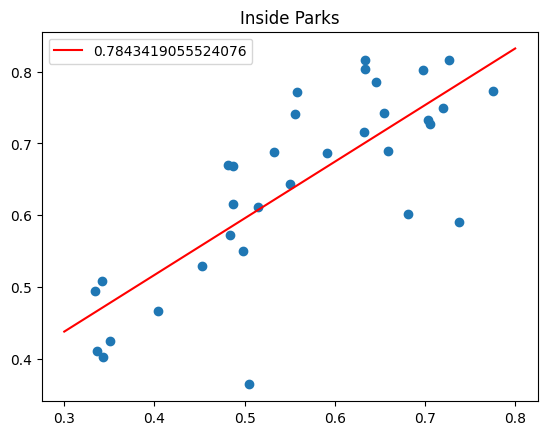

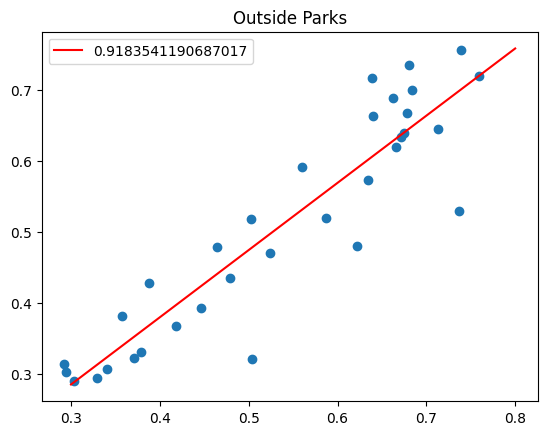

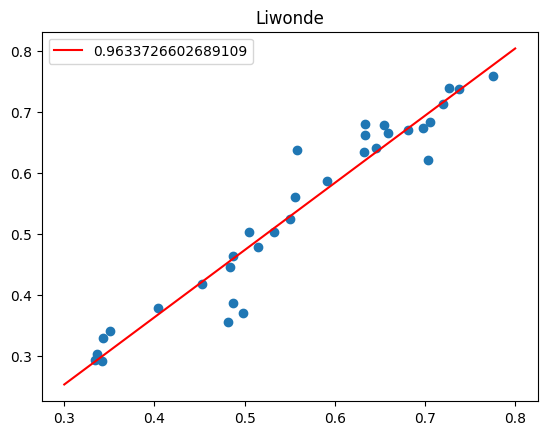

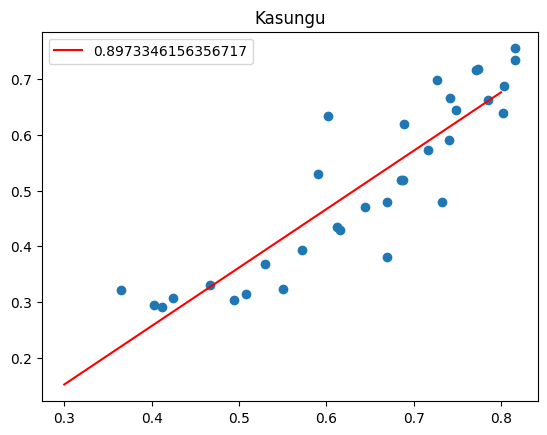

In [51]:
plot_correlate(ndvi_means["inside"][0],ndvi_means["inside"][1], "Inside Parks")
plot_correlate(ndvi_means["outside"][0],ndvi_means["outside"][1], "Outside Parks")
plot_correlate(ndvi_means["inside"][0],ndvi_means["outside"][0], "Liwonde")
plot_correlate(ndvi_means["inside"][1],ndvi_means["outside"][1], "Kasungu")

In [52]:
len(ndvi_means["inside"][0]), len(ndvi_means["inside"][1])

(33, 33)

In [44]:
result = linregress(ndvi_means[0], ndvi_means[1])
x = np.linspace(0.3, 0.8, 100)
best_fit = result.slope*x + result.intercept

Text(0.5, 1.0, 'Outside')

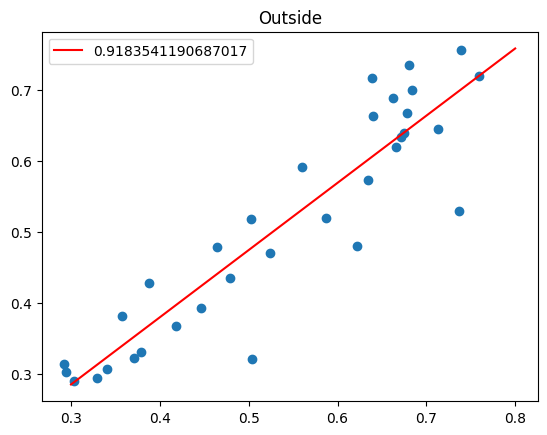

In [42]:
plt.plot(ndvi_means[0], ndvi_means[1], 'o')
plt.plot(x, best_fit, 'red', label=result.rvalue)
plt.legend()
plt.title("Outside")

Text(0.5, 1.0, 'Inside')

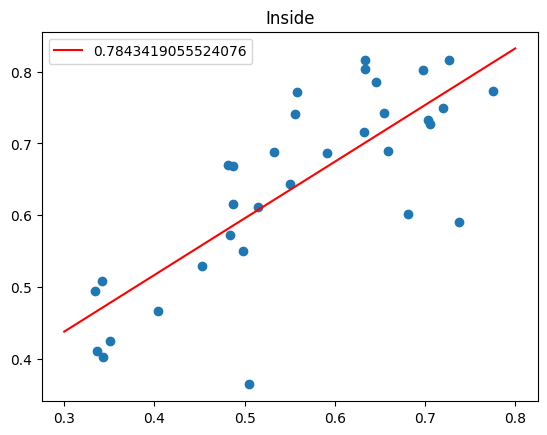

In [45]:
# copy and paste, just change variables
plt.plot(ndvi_means[0], ndvi_means[1], 'o')
plt.plot(x, best_fit, 'red', label=result.rvalue)
plt.legend()
plt.title("Inside")


In [20]:
dt_arr = np.array([datetime.strptime(dr, "%Y_%m_%d_NDVI") for dr in date_row[:-1]])

In [53]:
dt_arr

array([datetime.datetime(2023, 1, 1, 0, 0),
       datetime.datetime(2023, 1, 17, 0, 0),
       datetime.datetime(2023, 2, 2, 0, 0),
       datetime.datetime(2023, 2, 18, 0, 0),
       datetime.datetime(2023, 3, 6, 0, 0),
       datetime.datetime(2023, 3, 22, 0, 0),
       datetime.datetime(2023, 4, 7, 0, 0),
       datetime.datetime(2023, 4, 23, 0, 0),
       datetime.datetime(2023, 5, 9, 0, 0),
       datetime.datetime(2023, 5, 25, 0, 0),
       datetime.datetime(2023, 6, 10, 0, 0),
       datetime.datetime(2023, 6, 26, 0, 0),
       datetime.datetime(2023, 7, 12, 0, 0),
       datetime.datetime(2023, 7, 28, 0, 0),
       datetime.datetime(2023, 8, 13, 0, 0),
       datetime.datetime(2023, 8, 29, 0, 0),
       datetime.datetime(2023, 9, 14, 0, 0),
       datetime.datetime(2023, 9, 30, 0, 0),
       datetime.datetime(2023, 10, 16, 0, 0),
       datetime.datetime(2023, 11, 1, 0, 0),
       datetime.datetime(2023, 11, 17, 0, 0),
       datetime.datetime(2023, 12, 3, 0, 0),
       dateti

In [21]:
ndvi_mean_outside = np.array(data_row[:-1], dtype=float)

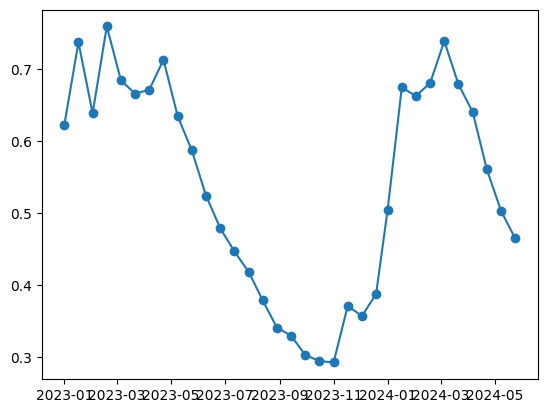

In [24]:
import matplotlib.pyplot as plt
plt.plot(dt_arr, ndvi_mean_outside, 'o-')

In [114]:
mean_in_region(ndvi_col.first())

In [154]:
mean_ndvi = ndvi_col.map(mean_in_region)

In [159]:
print(mean_ndvi.getString("NDVI"))

ee.String({
  "functionInvocationValue": {
    "functionName": "Element.getString",
    "arguments": {
      "object": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_0_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.reduceRegion",
                    "arguments": {
                      "geometry": {
                        "functionInvocationValue": {
                          "functionName": "Collection.geometry",
                          "arguments": {
                            "collection": {
                              "functionInvocationValue": {
                                "functionName": "Collection",
                                "arguments": {
                                  "

In [130]:
ndvi_col.flatten().toList(33)

EEException: The input collection must be a collection of collections, but the element with id 2023_01_01 was <Image<[NDVI]>>, which is not a collection.

In [47]:
np_arr_file = "/data/tapas/cnn_lstm/malawi/cnn_lstm_training/flattened_arrs/3D_nonstatic_v1_national_parks.npy"
all_arr_file = "/data/tapas/cnn_lstm/malawi/cnn_lstm_training/nonstatic/nonstatic_training_v0.npy"
np_arrs = np.load(np_arr_file)
all_arrs = np.load(all_arr_file)


In [97]:
del all_arrs

In [52]:
import matplotlib.pyplot as plt

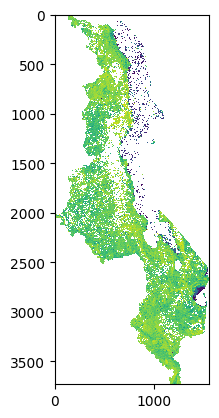

In [55]:
plt.imshow(all_arrs[0,:,:,0], interpolation="nearest")

In [65]:
np_arrs[0,:,0].shape

(362124,)

In [187]:
"/home/dualta/tapas/aiclimatise/transformer_v2/middle_malawi.geojson"

'/home/dualta/tapas/aiclimatise/transformer_v2/middle_malawi.geojson'